In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import viridis
import os
import shutil
import bisect

In [2]:
class DestinationExistsError(Exception):
    """Exception raised when the destination folder already exists."""
    pass

def create_modified_path(folder_path, work_path):
    """Creates new """
    try:
        if os.path.exists(work_path):
            raise DestinationExistsError(f"'{work_path}' already exists.")
        shutil.copytree(folder_path, work_path)
        file_names = [f for f in os.listdir(work_path) if f.endswith('.dat')]

        # Define column names and add angles. This choice is specific to the measurment
        column_names = ['ts', 'x_val', 'y_val', 'angle']

        for i, file_name in enumerate(file_names):
            file_path = os.path.join(work_path, file_name)
            
            # Open the input file
            with open(file_path, 'r') as file:
                data = file.read()

            # Replace commas with periods
            data = data.replace(',', '.')

            # Write the modified data to a new file
            with open(file_path, 'w') as file:
                file.write(data)

            # Read lines from the file
            with open(file_path, 'r') as file:
                lines = file.readlines()
            
            # Add angle to the end of each line
            modified_lines = [line.rstrip() + f'\t{i * 5}\n' for line in lines]
            modified_lines.insert(0, '\t'.join(column_names) + '\n')

            
            # Write modified lines back to the file
            with open(file_path, 'w') as file:
                file.writelines(modified_lines)
    except DestinationExistsError as e:
        print(f"Error: {e}")

def make_data_frame(work_path):
    """Returns data frame"""
    file_names = [f for f in os.listdir(work_path) if f.endswith('.dat')]

    dfs = []
    for file_name in file_names:
        file_path = os.path.join(work_path, file_name)
        
        # Read the first line to get column names
        with open(file_path, 'r') as file:
            columns = file.readline().rstrip().split('\t')
        
        # Read the rest of the file into a DataFrame
        df = pd.read_csv(file_path, delimiter='\t', skiprows=1, names=columns)
        df.dropna(inplace=True)
        
        # Append the DataFrame to the list
        dfs.append(df)

    # Concatenate all DataFrames into one big DataFrame
    df = pd.concat(dfs, ignore_index=True)
    return df

In [3]:
# load and modify data, place it in a new path and create a data frame
folders = ['20240418_120658_refP14981_ZnTe200µm_40mW_Bm1',
           'Data_for_Filip//24_04_2024//20240424_175636_DSOref_50mW_theta249deg_Bm1_PtCFB_phi_rot',
           'Data_for_Filip//24_04_2024//20240424_190529_DSOref_50mW_theta159deg_Bm1_PtCFB_phi_rot',
           'Data_for_Filip//25_04_2024//20240425_125028_DSOref_50mW_theta204deg_Bm1_PtCFB_phi_rot']
folder_path1 = folders[0]
work_path1 = 'Data//' + folder_path1 + '_modified'
folder_path2 = folders[1]
work_path2 = 'Data//' + folder_path2 + '_modified'
folder_path3 = folders[2]
work_path3 = 'Data//' + folder_path3 + '_modified'
folder_path4 = folders[3]
work_path4 = 'Data//' + folder_path4 + '_modified'
create_modified_path(folder_path1, work_path1)
create_modified_path(folder_path2, work_path2)
create_modified_path(folder_path3, work_path3)
create_modified_path(folder_path4, work_path4)
df1 = make_data_frame(work_path1)
df2 = make_data_frame(work_path2)
df3 = make_data_frame(work_path3)
df4 = make_data_frame(work_path4)
df2.head()

Error: 'Data//20240418_120658_refP14981_ZnTe200µm_40mW_Bm1_modified' already exists.
Error: 'Data//Data_for_Filip//24_04_2024//20240424_175636_DSOref_50mW_theta249deg_Bm1_PtCFB_phi_rot_modified' already exists.
Error: 'Data//Data_for_Filip//24_04_2024//20240424_190529_DSOref_50mW_theta159deg_Bm1_PtCFB_phi_rot_modified' already exists.
Error: 'Data//Data_for_Filip//25_04_2024//20240425_125028_DSOref_50mW_theta204deg_Bm1_PtCFB_phi_rot_modified' already exists.


,ts,x_val,y_val,angle
0,-95.50,-0.000004,-0.000011,0
1,-95.49,-0.000008,-0.000016,0
2,-95.48,-0.000011,-0.000016,0
3,-95.47,-0.000013,-0.000014,0
4,-95.46,-0.000011,-0.000009,0


In [46]:
def plot_intensity(dfs,x,y,angle):
    fig, axs = plt.subplots(1,1)
    for df in dfs:
        df = df[df['angle'] == angle]
        axs.plot(df[x],df[y])

def angular_plot(dfs,x,y):
    # Generate sample data
    fig, axs = plt.subplots(1, 1, figsize=(12, 5), subplot_kw=dict(projection='polar'))
    labels = []
    for i in range(len(dfs)):
        labels.append(f'plot{i+1}')
    for i, df in enumerate(dfs):
        angles = df[x]  # Angles from 0 to 360 degrees
        radial_distances = df[y]  # Example radial distances (sin function for demonstration)
        radial_distances[0] = radial_distances[len(radial_distances) - 1] = (radial_distances[0] + radial_distances[len(radial_distances) - 1]) / 2

        # # Create polar plot
        # plt.figure(figsize=(5,5))
        # ax = plt.subplot(111, projection='polar')

        # Plot data
        axs.plot(np.deg2rad(angles), radial_distances, linewidth=2, label=labels[i])

        # Set title and labels
        axs.set_title('Radial Plot', pad=20)
        axs.set_xlabel('Angle (degrees)')
        axs.set_ylabel('Radial Distance')

        # Show plot
    axs.legend()
    plt.show()

def angular_plot_comparison(dfs,x,y):
    if len(dfs) > 2: dfs = dfs[:2]
    # Create polar plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), subplot_kw=dict(projection='polar'))
    # Generate sample data
    for i, df in enumerate(dfs):
        angles = df[x]  # Angles from 0 to 360 degrees
        radial_distances = df[y]  # Example radial distances (sin function for demonstration)
        radial_distances[0] = radial_distances[len(radial_distances) - 1] = (radial_distances[0] + radial_distances[len(radial_distances) - 1]) / 2

        # Plot data
        axs[i].plot(np.deg2rad(angles), radial_distances, color='blue', linewidth=2)

        # Set title and labels
        axs[i].set_title('Radial Plot', pad=20)
        axs[i].set_xlabel('Angle (degrees)')
        axs[i].set_ylabel('Radial Distance')

        # Show plot
    plt.show()

def plot_fft(dfs,x,angles):
    fig, ax = plt.subplots(figsize=(8,5))
    for i,df in enumerate(dfs):
        for angle in angles:
            # Compute FFT for 'x' column
            df_temp = df[df['angle']==angle]
            fft_x = np.fft.fft(df_temp[x])
            
            # Compute the frequencies
            N = len(df_temp[x])
            timestep = 0.01  # Assuming each data point is 1 unit of time
            freqs = np.fft.fftfreq(N, d=timestep)
            
            # Plot only the positive frequencies
            positive_freqs_mask = (freqs > 0) & (freqs <= 5)
            positive_freqs = freqs[positive_freqs_mask]
            positive_fft_x = np.abs(fft_x)[positive_freqs_mask]
            
            # Plot the FFT result using plt.subplots()
            ax.plot(positive_freqs, positive_fft_x, label='df' + str(i+1) + ', angle='+str(angle) + '°')
    ax.set_title('FFT of x')
    ax.set_xlabel('Frequency(THz)')
    ax.set_ylabel('Magnitude')
    ax.grid(True)
    ax.legend()
    plt.show()

def closest_index(arr, omega):
    """Return the index of the closest value to omega in the array arr."""
    idx = np.abs(arr - omega).argmin()
    return idx

def plot_fft_phi_omega(dfs,x,omega):
    fig, ax = plt.subplots(figsize=(8,5))
    angles = np.arange(0,365,5)
    intensity = np.zeros(len(angles))
    for i, df in enumerate(dfs):
        for j, angle in enumerate(angles):
            # Compute FFT for 'x' column
            df_temp = df[df['angle']==angle]
            fft_x = np.fft.fft(df_temp[x])
            
            # Compute the frequencies
            N = len(df_temp[x])
            timestep = 0.01  # Assuming each data point is 1 unit of time
            freqs = np.fft.fftfreq(N, d=timestep)

            # Find the intensity corresponding to omega
            intensity[j] = fft_x[closest_index(freqs, omega)]
        
        # Plot the FFT result using plt.subplots()
        ax.plot(angles, intensity, label= 'df' + str(i+1) + ', ω=' + str(omega))
        ax.set_title('FFT of x')
        ax.set_xlabel('Frequency(THz)')
        ax.set_ylabel('Magnitude')
        ax.grid(True)
    ax.legend()
    plt.show()

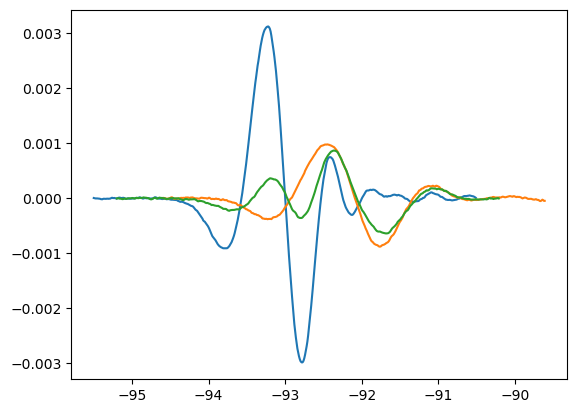

In [47]:
dfs = [df2,df3,df4]
angle=0
plot_intensity(dfs,'ts','x_val',angle)

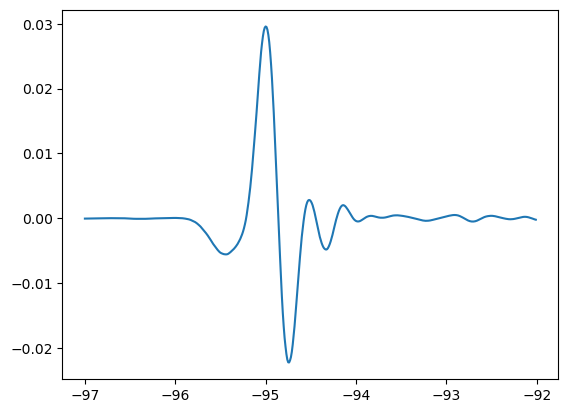

In [48]:
dft1 = df1[df1['angle'] == 20]
plt.plot(dft1['ts'], dft1['x_val'])

ValueError: Invalid number of FFT data points (0) specified.

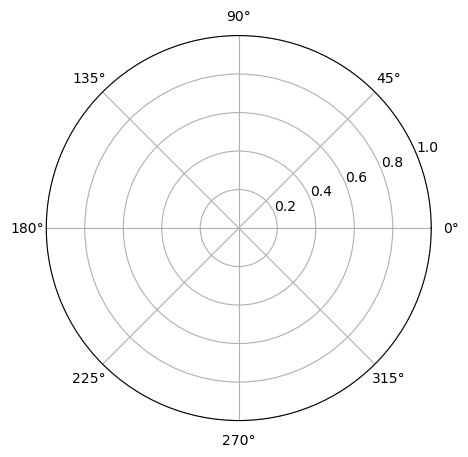

In [49]:
dfs = [df2]
angular_plot_fft_phi_omega(dfs, 'x_val', 1)

C:\Users\milan\AppData\Local\Temp\ipykernel_14340\472789596.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  intensity[j] = fft_x[closest_index(freqs, omega)]


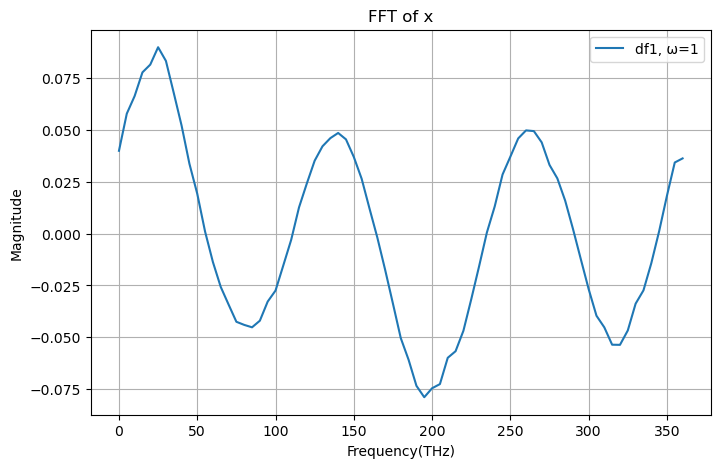

In [44]:
plot_fft_phi_omega(dfs, 'x_val', 1)

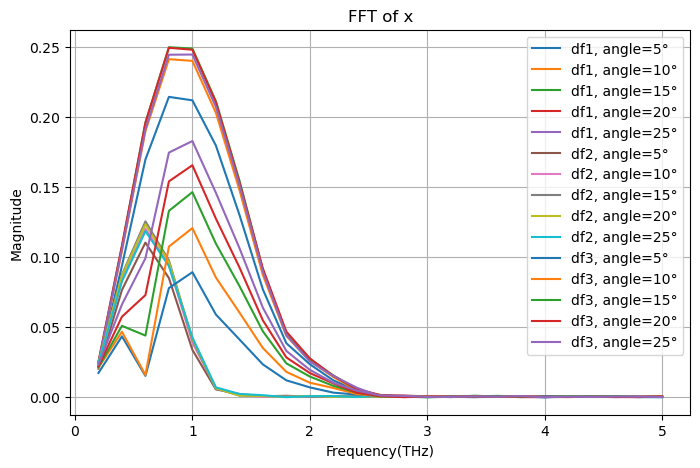

In [233]:
angles = np.arange(5,30,5)
# angles = [15,20,25,30,35]
plot_fft(dfs, 'x_val', angles)

In [234]:
def max_abs_with_sign(series):
    """ Maximum detected intensity for each angle """
    # return max(max(series), -min(series))
    return max(series, key=abs)
    
def max_ts_with_max_abs(series_ts, series_x_val):
    """ Time step at which the maximal angle occurs """
    max_abs = max(series_x_val, key=abs)
    max_ts = series_ts[series_x_val.abs() == abs(max_abs)].iloc[0]
    return max_ts

def peak_to_peak(series):
    return max(series) - min(series)

max_valuesx = [df.groupby('angle')['x_val'].agg(max_abs_with_sign).reset_index() for df in dfs]
max_valuesy = [df.groupby('angle')['y_val'].agg(max_abs_with_sign).reset_index() for df in dfs]
peak_to_peakx = [df.groupby('angle')['x_val'].agg(peak_to_peak).reset_index() for df in dfs]
peak_to_peaky = [df.groupby('angle')['y_val'].agg(peak_to_peak).reset_index() for df in dfs]
max_val_position = [df.groupby('angle').apply(lambda x: max_ts_with_max_abs(x['ts'], x['x_val'])).reset_index(name='ts') for df in dfs]


C:\Users\milan\AppData\Local\Temp\ipykernel_21036\2123359300.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  radial_distances[0] = radial_distances[len(radial_distances) - 1] = (radial_distances[0] + radial_distances[len(radial_distances) - 1]) / 2


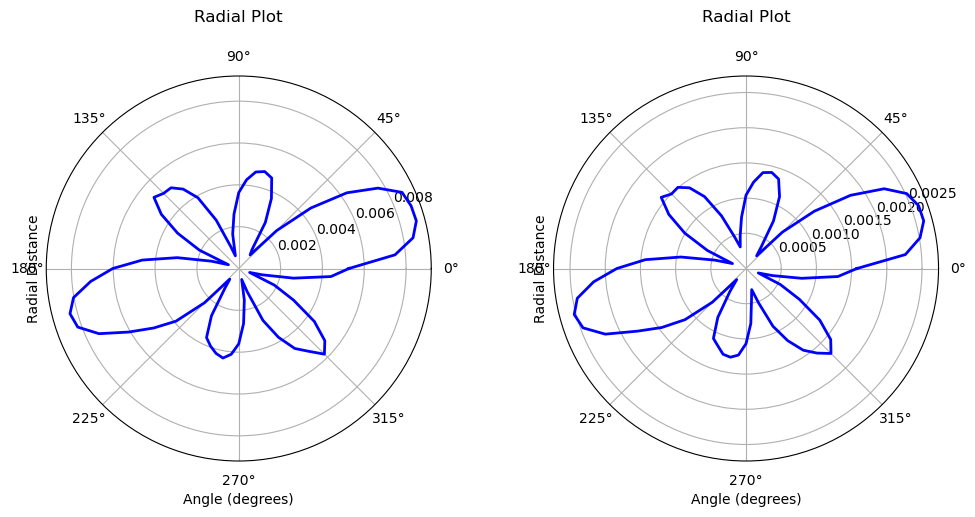

In [235]:
angular_plot_comparison(peak_to_peakx, 'angle', 'x_val')

In [237]:
# angular_plot(max_valuesx, 'angle', 'x_val')


C:\Users\milan\AppData\Local\Temp\ipykernel_21036\2123359300.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  radial_distances[0] = radial_distances[len(radial_distances) - 1] = (radial_distances[0] + radial_distances[len(radial_distances) - 1]) / 2


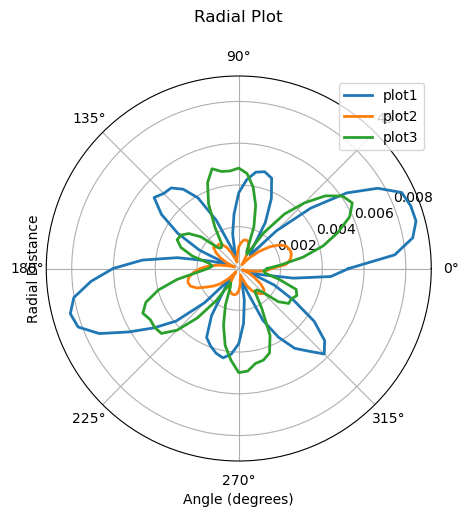

In [238]:
angular_plot(peak_to_peakx, 'angle', 'x_val')

Text(0, 0.5, 'Peak')

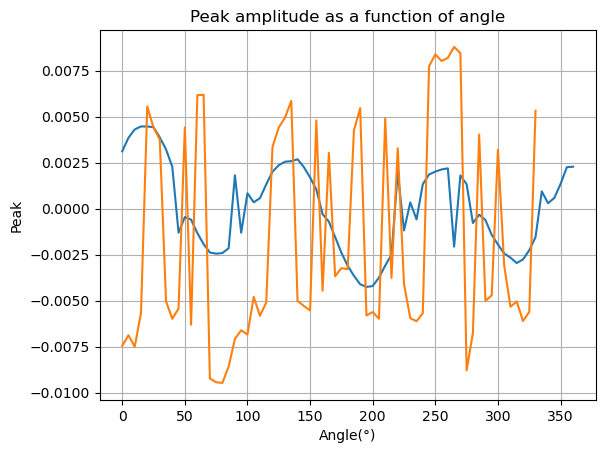

In [239]:
plt.grid('True')
plt.plot(max_valuesx[0]['angle'], max_valuesx[0]['x_val'])
plt.plot(max_valuesy[0]['angle'].shift(6), max_valuesy[0]['y_val']*100)
plt.title('Peak amplitude as a function of angle')
plt.xlabel('Angle(°)')
plt.ylabel('Peak')

Text(0, 0.5, 'max_ts')

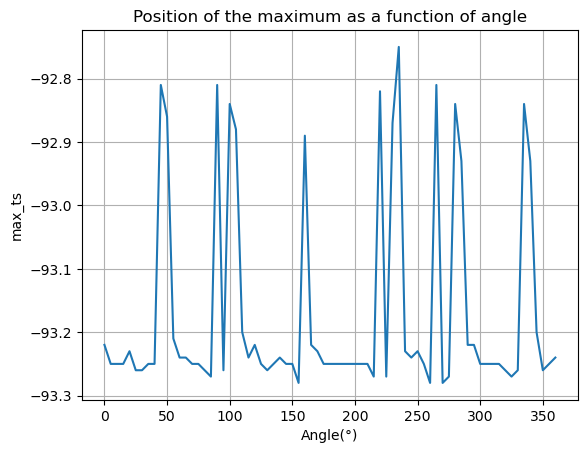

In [240]:
plt.grid('True')
plt.plot(max_val_position[0]['angle'], max_val_position[0]['ts'])
plt.title('Position of the maximum as a function of angle')
plt.xlabel('Angle(°)')
plt.ylabel('max_ts')

In [241]:
def plot_intensity(angles, df):
    """
    Plot x_val against time (ts) for given angle values.
    
    Parameters:
    angles (list or float): List of angle values or a single angle value.
    df (DataFrame): DataFrame containing the data.
    """
    if np.size(angles) == 1:
        angles = [angles]

    # Define the colormap and normalization
    cmap = viridis
    norm = Normalize(vmin=min(angles), vmax=max(angles))
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for angle in angles:
        filtered_df = df[df['angle'] == angle]  # Replace 'angle_column_name' with your actual column name
        
        # Plot x_val against time with colormap based on angle
        # ax.scatter(filtered_df['ts'], filtered_df['x_val'], c=[cmap(norm(angle))] * len(filtered_df), marker='o', label=f'{angle} degrees')
        ax.plot(filtered_df['ts'], filtered_df['x_val'], marker='o', linestyle='-', color=cmap(norm(angle)), label=f'{angle} degrees')


    ax.set_title('x_val vs Time')
    ax.set_xlabel('Time ([ps])')
    ax.set_ylabel('x_val')
    ax.grid(True)
    ax.legend()

    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label='Angle (degrees)')

    plt.show()

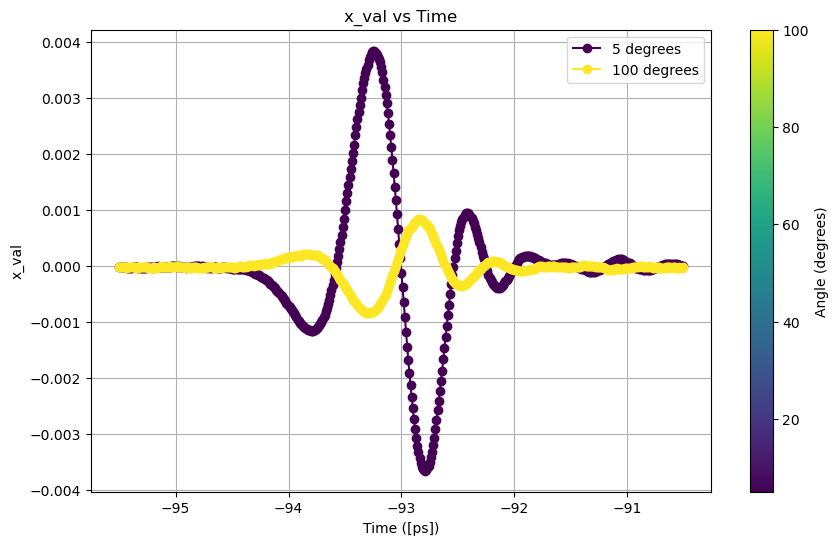

In [242]:
angles = [5,100]
plot_intensity(angles, dfs[0])

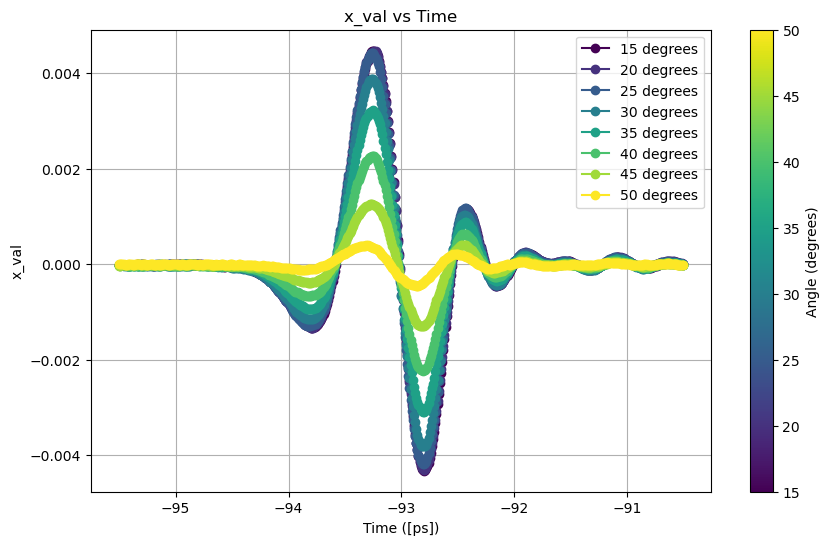

In [243]:
angles = [15,20,25,30,35,40,45,50]
plot_intensity(angles, dfs[0])